On recommence en mettant la boucle et en ajoutant la baseline : 

##
<center><span style="color: seagreen; font-size: 50px; font-style: bold">Pipeline d'analyse de spectres de spectroscopie Raman avec méthode SERS pour titration du Cuivre</span></center>


<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <title>Pipeline d'analyse de spectre de spectroscopie Raman avec méthode SERS pour titration du Cuivre</title>
    <style>
        body {
            font-family: Arial, sans-serif;
        }
        h1 {
            color: skyblue;
            font-size: 24px;
        }
        p, li {
            font-size: 16px;
        }
        .green-text{
            color: DarkSeaGreen;
        }
    </style>
</head>
<body>
    <h1>Analyse spectroscopique</h1>
    <p>Ce code permet d'analyser les données issues de spectroscope Raman. Les données doivent être données dans des fichiers standarisé ".txt". Le code fonctionne comme suit: </p>
    <ol>
        <li><strong class="green-text">Récupération des spectres :</strong> Collecte de tous les spectres issus d'une même expérience.</li>
        <li><strong class="green-text"> Pré-traitement:</strong> Soustraction d'une base-line pour uniformisé les spectres.</li>
        <li><strong class="green-text"> Téléchargement des métadonnés de l'expérience:</strong> Un tableur récapitulant l'intégralité des manipulations lors de l'expérience est chargé pour compléter les données nécessaires à la titration.</li>
        <li><strong class="green-text"> Hauteur de pics:</strong> Lecture de la valeur des pics définis, et calcul de leur rapport pour chaque mesure.</li>
        <li><strong class="green-text"Tracè des courbes de titrations :</strong> Application de méthodes statistiques aux trajectoires conservées. Les données peuvent être séparées en deux populations pour un traitement spécifique si nécessaire.</li>
    </ol>
</body>
</html>


<span style="color: skyblue; font-size: 20px; font-style: bold">Chargement des librairies.</span>

In [310]:
import os
import re
import itertools
import numpy as np
import pandas as pd
from pybaselines import Baseline
from plotnine import ggplot, aes, geom_point, geom_line, theme_bw, labs, scale_color_brewer, theme, scale_x_continuous, ylim, xlim
import matplotlib.pyplot as plt
import plotly.express as px

<span style="color: skyblue; font-size: 20px; font-style: bold"> Paramètresde l'étude </span>

In [311]:
EXPERIMENT_NAME = "AS004"
WAVELENGTH = "532nm"
EXPERIMENT_FOLDER = EXPERIMENT_NAME + "_" +WAVELENGTH
data_dir = os.path.join('/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/', EXPERIMENT_FOLDER)

<span style="color: skyblue; font-size: 20px; font-style: bold"> Téléchargement des méta-donnés de l'expérience </span>

In [312]:
# Lecture du fichier Excel de métadonnées :
metadata_path = "/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/"
metadata_df = pd.read_excel(metadata_path + EXPERIMENT_NAME + "_metadata.xlsx", skiprows=1)
metadata_df.head()

,Spectrum name,Sample description,nb average,laser.pwr,laser.WL (nm),acq.time (s),pH,C(EGTA) (µM),C(Cu) (nM),C(Ag) (mM),n(EGTA) (mol)
0,AS004_01,Cuvette BRB,1,30,532,3,NaN,0.00,0,0,0.000000e+00
1,AS004_02,S0,1,30,532,3,8.08,0.00,491,1,0.000000e+00
2,AS004_03,S500,1,30,532,3,NaN,0.22,491,1,1.166000e-10
3,AS004_04,S1000,1,30,532,3,NaN,0.44,491,1,2.332000e-10
4,AS004_05,S1500,1,30,532,3,NaN,0.66,491,1,3.498000e-10


<span style="color: skyblue; font-size: 20px; font-style: bold"> Liste des fichiers de la manip </span>

In [313]:
spectrocopy_files = [f for f in os.listdir(data_dir)
                    if f.endswith('.txt')]

# trie dans l'ordre croissant en extrayant la partie numérique
spectrocopy_files = sorted(
    spectrocopy_files,
    key=lambda x: int(re.search(r'_(\d+)\.txt$', x).group(1)) 
)

spectrocopy_files

['AS004_01.txt',
 'AS004_02.txt',
 'AS004_03.txt',
 'AS004_04.txt',
 'AS004_05.txt',
 'AS004_06.txt',
 'AS004_07.txt',
 'AS004_08.txt',
 'AS004_09.txt',
 'AS004_10.txt',
 'AS004_11.txt',
 'AS004_12.txt',
 'AS004_13.txt',
 'AS004_14.txt']

In [314]:
# file_path = os.path.join(data_dir, spectrocopy_files[1])
# header_idx = next(i for i, line in enumerate(lines)
#                 if line.strip().startswith('Pixel;'))
# prout = pd.read_csv(file_path,
#                     skiprows=header_idx,
#                     sep=";",
#                     decimal=",",
#                     encoding="utf-8",
#                     skipinitialspace=True,
#                     na_values=["", " ", "   ", "\t"],
#                     keep_default_na=True)
# prout.columns

<span style="color: skyblue; font-size: 20px; font-style: bold"> Démonstration de la soustraction de la baseLine sur spectre </span>

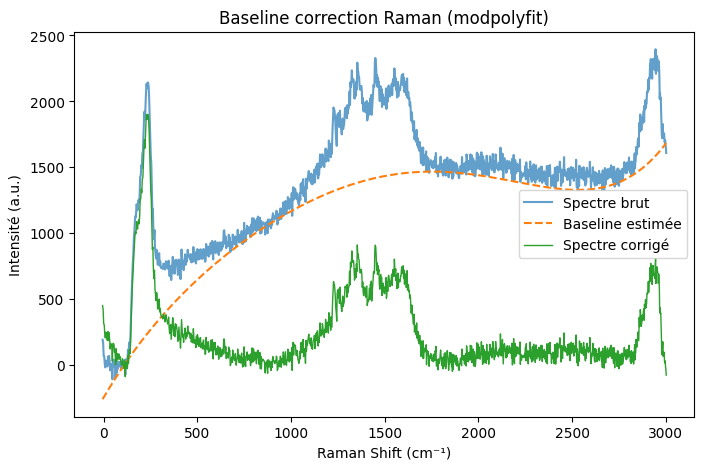

In [315]:
# Exemple : on prend un seul spectre
file_path = os.path.join(data_dir, spectrocopy_files[1])
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

header_idx = next(i for i, line in enumerate(lines)
                if line.strip().startswith('Pixel;'))

# lire le fichier
df = pd.read_csv(file_path,
                    skiprows=header_idx,
                    sep=";",
                    decimal=",",
                    encoding="utf-8",
                    skipinitialspace=True,
                    na_values=["", " ", "   ", "\t"],
                    keep_default_na=True)

# supprimer la dernière colonne si vide
if df.columns[-1].startswith("Unnamed"):
    df = df.iloc[:, :-1]

# convertir en numérique
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# garder seulement les colonnes utiles
temp = df[["Wavenumber", "Wavelength", "Raman Shift", "Dark Subtracted #1"]].copy()
temp = temp.dropna()

# baseline correction avec modpolyfit
x = temp["Raman Shift"].values
y = temp["Dark Subtracted #1"].values

# Initialiser le modèle
baseline_fitter = Baseline(x)

# Méthode polynomial modpolyfit (comme en R)
baseline, params = baseline_fitter.modpoly(y, poly_order=5)

# Corriger le spectre
y_corrected = y - baseline

# Affichage
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Spectre brut", alpha=0.7)
plt.plot(x, baseline, label="Baseline estimée", linestyle="--")
plt.plot(x, y_corrected, label="Spectre corrigé", linewidth=1)
plt.xlabel("Raman Shift (cm⁻¹)")
plt.ylabel("Intensité (a.u.)")
plt.legend()
plt.title("Baseline correction Raman (modpolyfit)")
plt.show()

<span style="color: skyblue; font-size: 20px; font-style: bold"> Téléchargement de tous les spectres, application de la baseline, et concaténation de tous les spectres en une seule variable "spectra_df" </span>

In [316]:
all_data = []

for fname in spectrocopy_files:   # ta liste triée
    file_path = os.path.join(data_dir, fname)

    # repérer la ligne de l'en-tête
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    header_idx = next(i for i, line in enumerate(lines)
                      if line.strip().startswith('Pixel;'))

    # lire le fichier
    df = pd.read_csv(file_path,
                     skiprows=header_idx,
                     sep=";",
                     decimal=",",
                     encoding="utf-8",
                     skipinitialspace=True,
                     na_values=["", " ", "   ", "\t"],
                     keep_default_na=True)

    # supprimer la dernière colonne si vide
    if df.columns[-1].startswith("Unnamed"):
        df = df.iloc[:, :-1]

    # convertir en numérique
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # garder seulement les colonnes utiles
    temp = df[["Wavenumber", "Wavelength", "Raman Shift", "Dark Subtracted #1"]].copy()
    temp = temp.dropna()

    # baseline correction avec modpolyfit
    x = temp["Raman Shift"].values
    y = temp["Dark Subtracted #1"].values
    baseline_fitter = Baseline(x)
    baseline, _ = baseline_fitter.modpoly(y, poly_order=5)

    # ajouter la colonne corrigée
    temp["Intensity_corrected"] = y - baseline
    temp = temp.dropna(subset=["Intensity_corrected"])

    # ajouter une colonne "fichier"
    temp["file"] = fname

    # stocker dans la liste
    all_data.append(temp)

# fusionner tous les fichiers
spectra_df = pd.concat(all_data, ignore_index=True)

spectra_df.head()
# print(spectra_df["file"].unique())

,Wavenumber,Wavelength,Raman Shift,Dark Subtracted #1,Intensity_corrected,file
0,18799.81,531.92,-4.95,299.3333,512.206956,AS004_01.txt
1,18796.91,532.00,-2.05,228.0000,435.224384,AS004_01.txt
2,18794.01,532.08,0.86,139.3333,340.952553,AS004_01.txt
3,18791.11,532.17,3.76,7.6667,203.763029,AS004_01.txt
4,18788.21,532.25,6.65,27.6667,218.321212,AS004_01.txt


In [317]:
spectra_df["file"].unique()

array(['AS004_01.txt', 'AS004_02.txt', 'AS004_03.txt', 'AS004_04.txt',
       'AS004_05.txt', 'AS004_06.txt', 'AS004_07.txt', 'AS004_08.txt',
       'AS004_09.txt', 'AS004_10.txt', 'AS004_11.txt', 'AS004_12.txt',
       'AS004_13.txt', 'AS004_14.txt'], dtype=object)

<span style="color: skyblue; font-size: 20px; font-style: bold"> Fusion entre datas et metadatas  </span>

In [318]:
#  Création d'une clé de jointure dans spectra_df 
# (on enlève ".txt" pour matcher le nom type"AS00X_Y" dans l'Excel
spectra_df["Spectrum name"] = spectra_df["file"].str.replace(".txt", "", regex=False)

# Fusion des deux tables : 
combined_df = pd.merge(
    spectra_df,
    metadata_df,
    on="Spectrum name",
    how="left"   # garde toutes les lignes de spectra_df
)
# cuvette BRB
cuvette_BRB = combined_df[combined_df["Sample description"] == "Cuvette BRB"]
# Supprimer les lignes avec "Cuvette BRB"
combined_df = combined_df[combined_df["Sample description"] != "Cuvette BRB"].copy()
# Print du résultat
combined_df.head(10)

# Sauvegarde
# combined_df.to_excel("Spectres_fusionnés.xlsx", index=False)

,Wavenumber,Wavelength,Raman Shift,Dark Subtracted #1,Intensity_corrected,file,Spectrum name,Sample description,nb average,laser.pwr,laser.WL (nm),acq.time (s),pH,C(EGTA) (µM),C(Cu) (nM),C(Ag) (mM),n(EGTA) (mol)
1295,18799.81,531.92,-4.95,192.3333,451.109803,AS004_02.txt,AS004_02,S0,1,30,532,3,8.08,0.0,491,1,0.0
1296,18796.91,532.00,-2.05,171.3333,423.053524,AS004_02.txt,AS004_02,S0,1,30,532,3,8.08,0.0,491,1,0.0
1297,18794.01,532.08,0.86,71.0000,315.668471,AS004_02.txt,AS004_02,S0,1,30,532,3,8.08,0.0,491,1,0.0
1298,18791.11,532.17,3.76,67.3333,305.002852,AS004_02.txt,AS004_02,S0,1,30,532,3,8.08,0.0,491,1,0.0
1299,18788.21,532.25,6.65,9.6667,240.389713,AS004_02.txt,AS004_02,S0,1,30,532,3,8.08,0.0,491,1,0.0
1300,18785.31,532.33,9.55,-17.3333,206.447327,AS004_02.txt,AS004_02,S0,1,30,532,3,8.08,0.0,491,1,0.0
1301,18782.42,532.41,12.45,33.3333,250.199623,AS004_02.txt,AS004_02,S0,1,30,532,3,8.08,0.0,491,1,0.0
1302,18779.52,532.49,15.34,28.6667,238.670344,AS004_02.txt,AS004_02,S0,1,30,532,3,8.08,0.0,491,1,0.0
1303,18776.63,532.58,18.24,-6.3333,196.811643,AS004_02.txt,AS004_02,S0,1,30,532,3,8.08,0.0,491,1,0.0
1304,18773.73,532.66,21.13,-10.0000,186.337371,AS004_02.txt,AS004_02,S0,1,30,532,3,8.08,0.0,491,1,0.0


In [319]:
combined_df['Sample description'].unique()

array(['S0', 'S500', 'S1000', 'S1500', 'S2000', 'S2500', 'S3000', 'S3500',
       'S4000', 'S4500', 'S5000', 'S0 bis', 'S5000 bis'], dtype=object)

<span style="color: skyblue; font-size: 20px; font-style: bold"> Spectre </span>

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/mizani/palettes.py:557: UserWarning:

Warning message:Brewer palette Paired has a maximum of 12 colors Returning the palette you asked for with that many colors

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/mizani/palettes.py:557: UserWarning:

Warning message:Brewer palette Paired has a maximum of 12 colors Returning the palette you asked for with that many colors



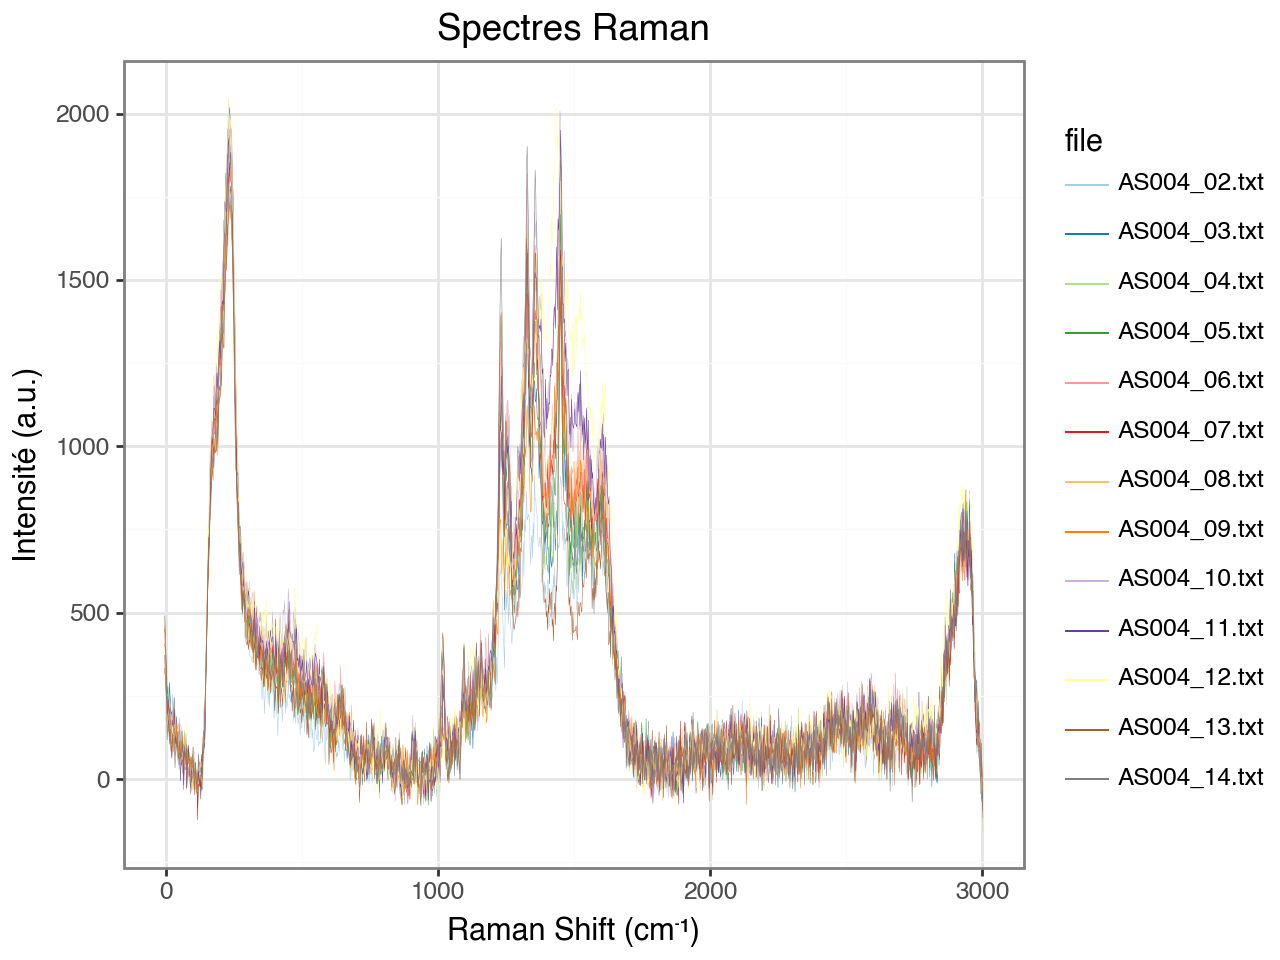

In [320]:
p = (
    ggplot(combined_df, aes(x="Raman Shift", y="Intensity_corrected", color="file"))
    + geom_line(size=0.1)
    + theme_bw()
    + labs(
        title="Spectres Raman",
        x="Raman Shift (cm⁻¹)",
        y="Intensité (a.u.)"
    )
    + scale_color_brewer(type='qual', palette='Paired')  # ou 'Dark2', 'Paired', etc.
)

p

<span style="color: skyblue; font-size: 20px; font-style: bold"> Spectre interactif </span>

In [321]:
# Spectres des cuvettes BRB

fig = px.line(cuvette_BRB, 
              x="Raman Shift", 
              y="Intensity_corrected", 
              color="file",
              title="Spectres Raman interactifs")

fig.update_layout(
    xaxis_title="Raman Shift (cm⁻¹)",
    yaxis_title="Intensité (a.u.)",
    width=1900,   # largeur en pixels
    height=1000   # hauteur en pixels
)

fig.show()

In [322]:
# Spectres
fig = px.line(combined_df, 
              x="Raman Shift", 
              y="Intensity_corrected", 
              color="file",
              title="Spectres Raman interactifs")

fig.update_layout(
    xaxis_title="Raman Shift (cm⁻¹)",
    yaxis_title="Intensité (a.u.)",
    width=1900,   # largeur en pixels
    height=1000   # hauteur en pixels
)

fig.show()

<span style="color: skyblue; font-size: 20px; font-style: bold"> Définitions des pics d'étude </span>

In [323]:
# Liste des pics d’intérêt (en cm⁻¹)
peaks = [1231, 1327, 1342, 1358, 1450] # 532nm
peaks = [412, 444, 471, 547, 1561] # 785nm

<span style="color: skyblue; font-size: 20px; font-style: bold"> Récupération des valeurs de pics </span>

In [324]:
# Largeur de la fenêtre de recherche autour de chaque pic
tolerance = 2  # ±5 cm⁻¹

results = []

for fname, group in combined_df.groupby("file"):
    spectrum = group.sort_values("Raman Shift")

    record = {"file": fname}

    for target in peaks:
        # on sélectionne la fenêtre autour du Raman Shift cible
        window = spectrum[
            (spectrum["Raman Shift"] >= target - tolerance) &
            (spectrum["Raman Shift"] <= target + tolerance)
        ]

        if not window.empty:
            # on prend le maximum corrigé dans cette zone
            record[f"I_{target}"] = window["Intensity_corrected"].max()
        else:
            record[f"I_{target}"] = np.nan

    results.append(record)

peak_intensities = pd.DataFrame(results)
peak_intensities.head()

,file,I_412,I_444,I_471,I_547,I_1561
0,AS004_02.txt,239.122313,213.003785,202.457963,210.261052,639.408919
1,AS004_03.txt,240.301733,406.437051,291.125636,296.739557,792.619218
2,AS004_04.txt,313.044742,415.727455,318.587084,300.060177,688.849020
3,AS004_05.txt,338.802387,326.309468,327.125796,322.213197,796.589299
4,AS004_06.txt,331.072519,417.472136,396.574351,376.623409,868.116675


In [325]:
for (target_a, target_b) in itertools.combinations(peaks, 2):
    peak_intensities[f"ratio_I_{target_a}_I_{target_b}"] = (
        peak_intensities[f"I_{target_a}"] / peak_intensities[f"I_{target_b}"]
    )
peak_intensities.head(10)

,file,I_412,I_444,I_471,I_547,I_1561,ratio_I_412_I_444,ratio_I_412_I_471,ratio_I_412_I_547,ratio_I_412_I_1561,ratio_I_444_I_471,ratio_I_444_I_547,ratio_I_444_I_1561,ratio_I_471_I_547,ratio_I_471_I_1561,ratio_I_547_I_1561
0,AS004_02.txt,239.122313,213.003785,202.457963,210.261052,639.408919,1.122620,1.181096,1.137264,0.373974,1.052089,1.013044,0.333126,0.962889,0.316633,0.328837
1,AS004_03.txt,240.301733,406.437051,291.125636,296.739557,792.619218,0.591240,0.825423,0.809807,0.303174,1.396088,1.369676,0.512777,0.981081,0.367296,0.374378
2,AS004_04.txt,313.044742,415.727455,318.587084,300.060177,688.849020,0.753005,0.982603,1.043273,0.454446,1.304910,1.385480,0.603510,1.061744,0.462492,0.435596
3,AS004_05.txt,338.802387,326.309468,327.125796,322.213197,796.589299,1.038285,1.035694,1.051485,0.425316,0.997505,1.012713,0.409633,1.015246,0.410658,0.404491
4,AS004_06.txt,331.072519,417.472136,396.574351,376.623409,868.116675,0.793041,0.834831,0.879055,0.381369,1.052696,1.108460,0.480894,1.052973,0.456821,0.433840
5,AS004_07.txt,325.038766,316.226970,332.833551,269.496633,821.900515,1.027865,0.976581,1.206096,0.395472,0.950105,1.173399,0.384751,1.235019,0.404956,0.327894
6,AS004_08.txt,338.041917,421.215590,420.967612,341.016168,833.728039,0.802539,0.803012,0.991278,0.405458,1.000589,1.235178,0.505219,1.234451,0.504922,0.409026
7,AS004_09.txt,277.878439,290.314818,314.752057,347.859372,709.422934,0.957162,0.882849,0.798824,0.391696,0.922360,0.834575,0.409227,0.904826,0.443673,0.490341
8,AS004_10.txt,391.277995,439.516512,468.958127,406.478330,926.405223,0.890246,0.834356,0.962605,0.422362,0.937219,1.081279,0.474432,1.153710,0.506213,0.438769
9,AS004_11.txt,400.543690,389.356573,389.303173,364.742947,864.210804,1.028732,1.028873,1.098153,0.463479,1.000137,1.067482,0.450534,1.067336,0.450472,0.422053


In [326]:
# Fusion des intensités avec les métadonnées
peak_intensities["Spectrum name"] = peak_intensities["file"].str.replace(".txt", "", regex=False)
merged = peak_intensities.merge(metadata_df, on="Spectrum name", how="left")
merged.head(10)

,file,I_412,I_444,I_471,I_547,I_1561,ratio_I_412_I_444,ratio_I_412_I_471,ratio_I_412_I_547,ratio_I_412_I_1561,...,Sample description,nb average,laser.pwr,laser.WL (nm),acq.time (s),pH,C(EGTA) (µM),C(Cu) (nM),C(Ag) (mM),n(EGTA) (mol)
0,AS004_02.txt,239.122313,213.003785,202.457963,210.261052,639.408919,1.122620,1.181096,1.137264,0.373974,...,S0,1,30,532,3,8.08,0.00,491,1,0.000000e+00
1,AS004_03.txt,240.301733,406.437051,291.125636,296.739557,792.619218,0.591240,0.825423,0.809807,0.303174,...,S500,1,30,532,3,NaN,0.22,491,1,1.166000e-10
2,AS004_04.txt,313.044742,415.727455,318.587084,300.060177,688.849020,0.753005,0.982603,1.043273,0.454446,...,S1000,1,30,532,3,NaN,0.44,491,1,2.332000e-10
3,AS004_05.txt,338.802387,326.309468,327.125796,322.213197,796.589299,1.038285,1.035694,1.051485,0.425316,...,S1500,1,30,532,3,NaN,0.66,491,1,3.498000e-10
4,AS004_06.txt,331.072519,417.472136,396.574351,376.623409,868.116675,0.793041,0.834831,0.879055,0.381369,...,S2000,1,30,532,3,NaN,0.88,491,1,4.664000e-10
5,AS004_07.txt,325.038766,316.226970,332.833551,269.496633,821.900515,1.027865,0.976581,1.206096,0.395472,...,S2500,1,30,532,3,NaN,1.10,491,1,5.830000e-10
6,AS004_08.txt,338.041917,421.215590,420.967612,341.016168,833.728039,0.802539,0.803012,0.991278,0.405458,...,S3000,1,30,532,3,NaN,1.32,491,1,6.996000e-10
7,AS004_09.txt,277.878439,290.314818,314.752057,347.859372,709.422934,0.957162,0.882849,0.798824,0.391696,...,S3500,1,30,532,3,NaN,1.54,491,1,8.162000e-10
8,AS004_10.txt,391.277995,439.516512,468.958127,406.478330,926.405223,0.890246,0.834356,0.962605,0.422362,...,S4000,1,30,532,3,NaN,1.76,491,1,9.328000e-10
9,AS004_11.txt,400.543690,389.356573,389.303173,364.742947,864.210804,1.028732,1.028873,1.098153,0.463479,...,S4500,1,30,532,3,NaN,1.98,491,1,1.049400e-09


<span style="color: skyblue; font-size: 20px; font-style: bold"> Calcul des ratios entre deux pics </span>

In [327]:
ratio_cols = [c for c in merged.columns if c.startswith("ratio_I_")]

In [328]:
# Restructurer les données en format long
df_ratios = merged.melt(
    id_vars=["n(EGTA) (mol)", "file"],
    value_vars=ratio_cols,
    var_name="Ratio",
    value_name="Value"
)

<span style="color: skyblue; font-size: 20px; font-style: bold"> Tracés des ratios en fonction de l'EGTA ajouté </span>

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/mizani/palettes.py:557: UserWarning:

Warning message:Brewer palette Dark2 has a maximum of 8 colors Returning the palette you asked for with that many colors

/Users/souchaud/Documents/Travail/CitizenSers/Spectroscopie/traitement_données/spectroscopie_raman/.spectroscopie_raman/lib/python3.13/site-packages/mizani/palettes.py:557: UserWarning:

Warning message:Brewer palette Dark2 has a maximum of 8 colors Returning the palette you asked for with that many colors



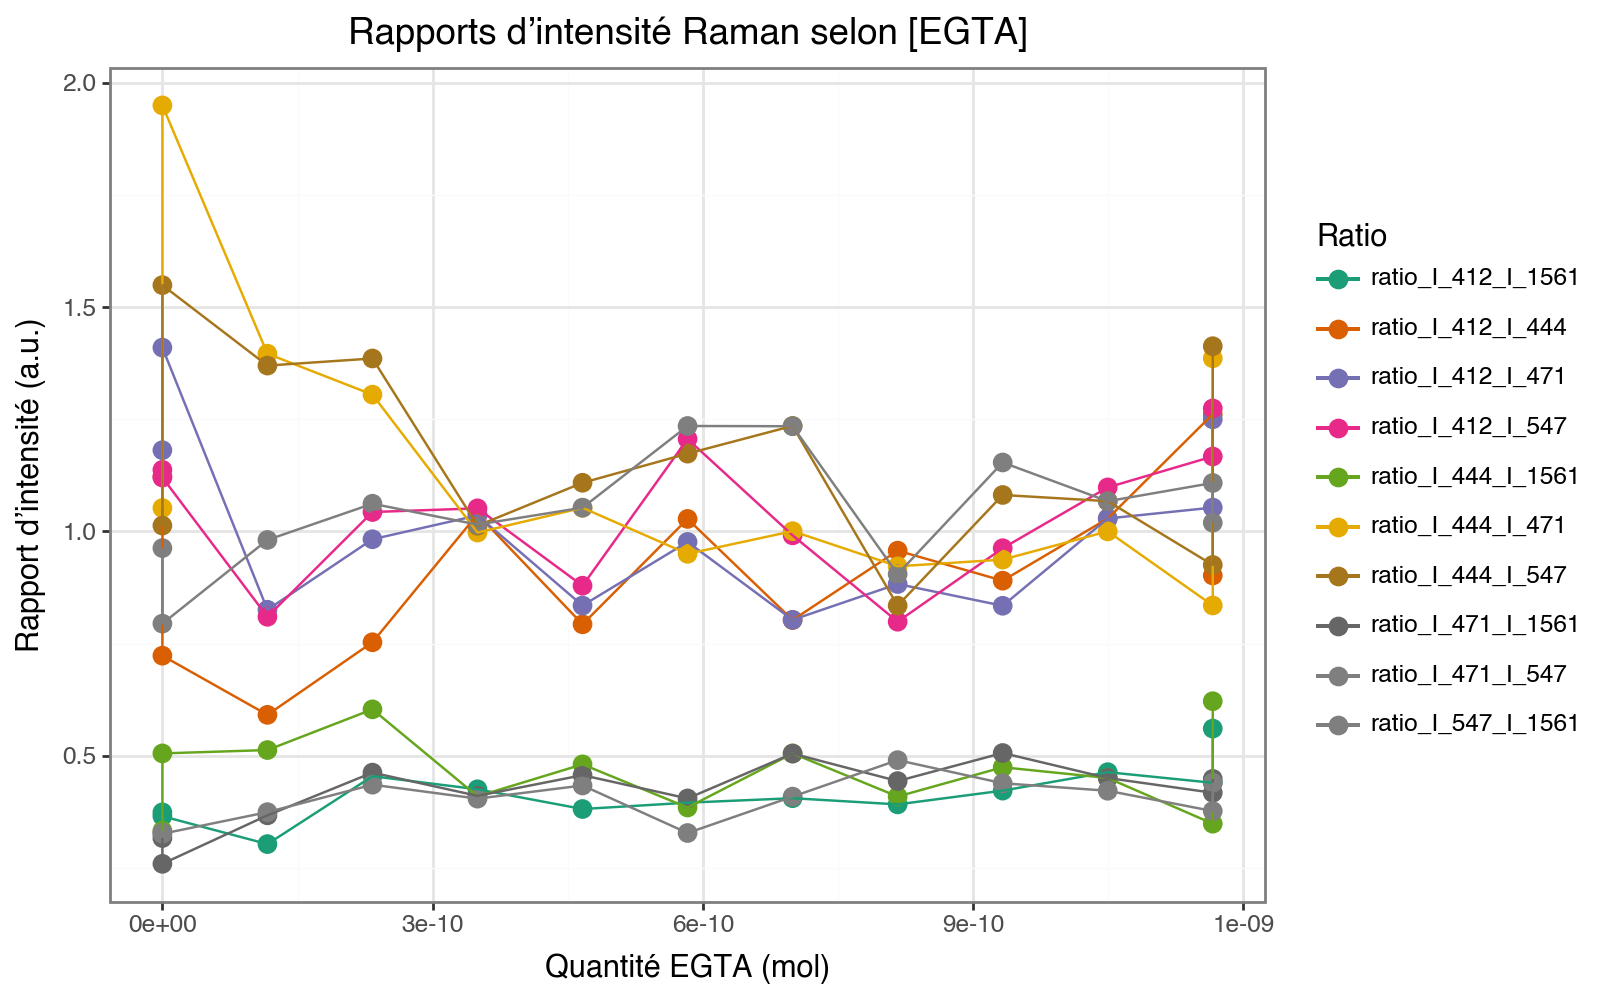

In [329]:
# Tracé
p = (
    ggplot(df_ratios, aes(x="n(EGTA) (mol)", y="Value", color="Ratio"))
    + geom_point(size=3)
    + geom_line(aes(group="Ratio"))
    + theme_bw()
    + labs(
        title="Rapports d’intensité Raman selon [EGTA]",
        x="Quantité EGTA (mol)",
        y="Rapport d’intensité (a.u.)"
    )
    + scale_color_brewer(type='qual', palette='Dark2')
    + scale_x_continuous(labels=lambda l: [f"{x:.0e}" for x in l])
    + theme(figure_size=(8, 5))
    # + ylim(0.4, 1.8)
    #  + xlim(0, 1.5e-9)
)

p